# Micrograd
В данной тетрадке будет реализована библиотека micrograd из курса [Андрея Карпаты](https://github.com/karpathy/micrograd).

В самом начале своей лекции, Андрей рассказывает проблема посчета градиентов при большом количестве неизвестных и что для этого используются специальные алгоритмы позволяющие определять влияние каждой из неизвестных на итоговый результат функции. Данный момент я опущу и сразу перейду к написанию библиотеке micrograd.

Все начинается с простого класса Value, который просто хранит в себе число.

In [1]:
%pip install graphviz
%pip install torch

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 1.9 MB/s  0:00:46m0:00:0100:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.7 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.9 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [torch]m 9/10 [torch]]x]s]
Note: you may need to restart the kernel to use updated packages.


In [209]:
import math
import random

In [203]:
class Value:
    # Для того, чтобы наши градиентые текли через наши переменные, 
    # необходимо создать указатели на детей каждой из переменных
    # Также необходимо понимать, какое действие было совершено над детьми
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    # Добавляем в класс сложение
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # "+" добавлен для накопления градиента
            other.grad += 1.0 * out.grad # "+" добавлен для накопления градиента

        out._backward = _backward
        return out 
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    # Добавялем умножение
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # "+" добавлен для накопления градиента
            other.grad += self.data * out.grad # "+" добавлен для накопления градиента
        out._backward = _backward
        return out 
    
    def __rmul__(self, other): # int * Value
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # "+" добавлен для накопления градиента
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supported int/float'
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    
    # Обрвтное распространение ошибки
    def backward(self):

        # Далее реализована Топологическая сортировка
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Классно было бы отрисовать полученный граф, для этого воспользуемся [Graphiz](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://graphviz.org/&ved=2ahUKEwipl9vz2rKPAxVxWkEAHRAhELcQFnoECAoQAQ&usg=AOvVaw2Rsf6ys4jVpugmODFYtwkL)

In [204]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label='{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [205]:
#входные данные
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#веса нейрона
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#смещение
b = Value(6.8813735870195432, label='b')
 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='0'
o.backward()

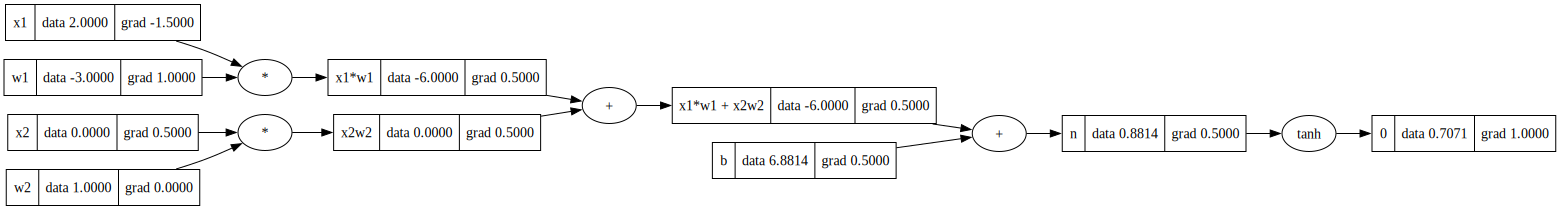

In [206]:
draw_dot(o)

In [207]:
#входные данные
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#веса нейрона
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#смещение
b = Value(6.8813735870195432, label='b')
 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
#---
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----
o.label='0'
o.backward()

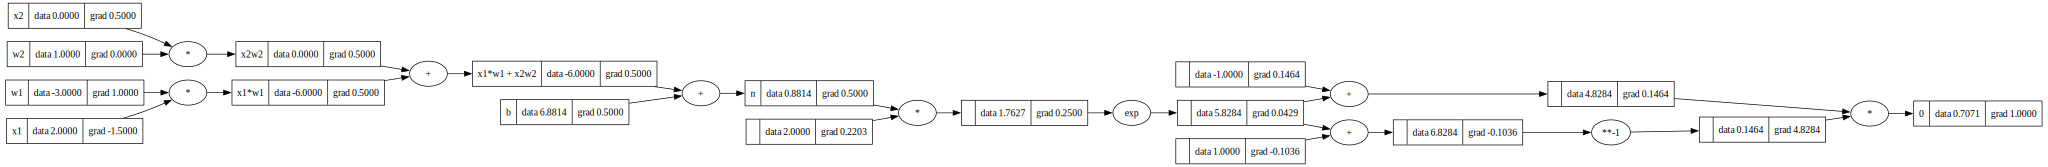

In [208]:
draw_dot(o)

# NN
В этом разделе будет создан класс, который будет представлять из себя просто перцептрон, состоящий из двух слоев.

- __init__ - в данной функции инициализации будет генерироваться веса и смещение для каждого из входного значения нейрона.
- 

In [376]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        activation = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.layer = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.layer]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.layer for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [389]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.28206765699903236)

In [393]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

for k in range(1000):
    #считаем наш ответ и ошибку
    ypred = [n(x) for x in xs]
    loss = sum(((yprd - ytrue)**2 for ytrue, yprd in zip(ys, ypred)), Value(0.0))
    
    #Обнуление градиентов
    for p in n.parameters():
        p.grad = 0.0
    #вычисляем градиенты
    loss.backward()

    #изменяем веса нейронов
    for p in n.parameters():
        p.data += -(0.02 * p.grad)
        p.grad = 0.0
    print(f'Step: {k}, Loss: {loss}, Predictions: {ypred}')

Step: 0, Loss: Value(data=0.00555288175180089), Predictions: [Value(data=0.9633583419140807), Value(data=-0.9754860815115282), Value(data=-0.9541903159115002), Value(data=0.9611308439946546)]
Step: 1, Loss: Value(data=0.005520212214323192), Predictions: [Value(data=0.9634739399264921), Value(data=-0.9755706811189904), Value(data=-0.9543156347150347), Value(data=0.9612416938276518)]
Step: 2, Loss: Value(data=0.005487922663753922), Predictions: [Value(data=0.9635884954874082), Value(data=-0.9756544866789946), Value(data=-0.9544399194221028), Value(data=0.9613515842270903)]
Step: 3, Loss: Value(data=0.005456006537374375), Predictions: [Value(data=0.9637020238884841), Value(data=-0.9757375101823448), Value(data=-0.9545631842291668), Value(data=0.9614605289600683)]
Step: 4, Loss: Value(data=0.005424457422253136), Predictions: [Value(data=0.9638145401123392), Value(data=-0.9758197633716982), Value(data=-0.9546854430607439), Value(data=0.9615685415190904)]
Step: 5, Loss: Value(data=0.00539326